## Import required libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading Dataset and Preprocessing

In [2]:
!unzip './dataset.zip' -d './data/'


from PIL import Image

X = []
y = []

for dirname, _, filenames in os.walk("./data/samples/"):
    for filename in filenames:
        try:
            path = os.path.join(dirname, filename)

            # Read image
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

            # Preprocessing steps
            image = cv2.adaptiveThreshold(
                image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0
            )
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
            image = cv2.dilate(image, np.ones((2, 2), np.uint8), iterations=1)
            image = cv2.GaussianBlur(image, (5, 5), 0)

            # Splitting up the image into sections of each character
            sections = np.array(
                [image[10:50, 30 + i * 20 : 50 + i * 20] for i in range(5)]
            )

            # Labelling segments with the image name
            for i, section in enumerate(sections):
                X.append(
                    tf.keras.preprocessing.image.img_to_array(Image.fromarray(section))
                )
                y.append(filename[i])

        except Exception as e:
            print(f"Error processing {filename}: {e}")

X = np.array(X)
y = np.array(y)

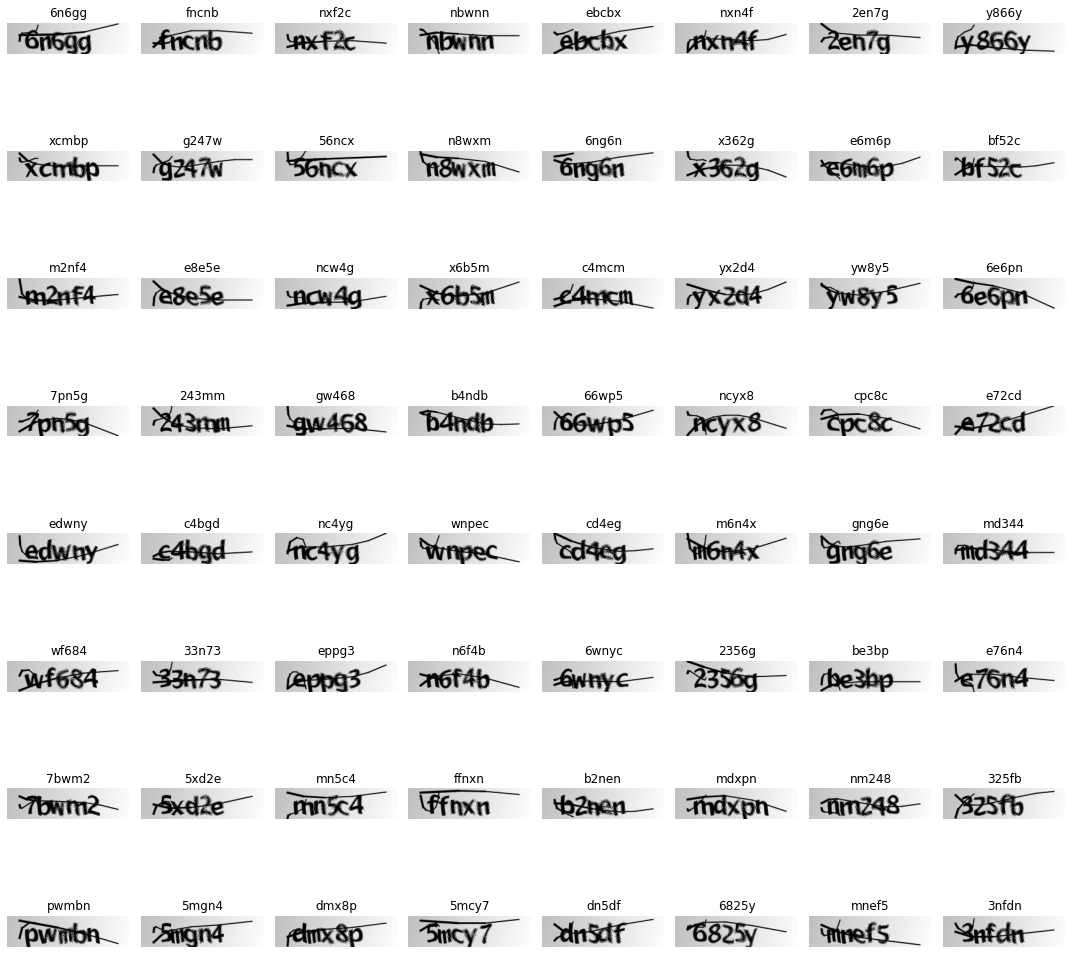

In [3]:
def display_images_in_grid(folder_path, grid_size=(8, 8)):
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))

    for i, filename in enumerate(os.listdir(folder_path)):
        if i >= grid_size[0] * grid_size[1]:
            break  # Stop iterating after filling the grid

        filepath = os.path.join(folder_path, filename)
        text = filename.split(".")[0]  # Extract text from filename

        # Read image and display with text
        img = Image.open(filepath)
        ax = axs[i // grid_size[1], i % grid_size[1]]
        ax.imshow(img)
        ax.set_title(text)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# Call the function with the path to the samples folder
display_images_in_grid("./data/samples/")

## Scaling and Encoding

In [4]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

# Convert X to float32 and normalize to range [0, 1]
X = X.astype("float32")
X /= 255

# Encode categorical labels y
y_le = LabelEncoder().fit_transform(y)  # Label encode categorical labels
y_ohe = OneHotEncoder(sparse=False).fit_transform(
    y_le.reshape(len(y_le), 1)
)  # One-hot encode categorical labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ohe, test_size=0.2, random_state=42
)

# Get dimensions for input shape
row, col = X.shape[1], X.shape[2]

# Get number of categories for output shape
categories = y_ohe.shape[1]

# Create a dictionary to map encoded labels back to original labels
info = {y_le[i]: y[i] for i in range(len(y))}

## Model Architecture

In [5]:
import tensorflow as tf

# Create a Sequential model
model = tf.keras.models.Sequential(
    [
        # Convolutional layers with ReLU activation and max pooling
        tf.keras.layers.Conv2D(
            filters=16, kernel_size=(3, 3), padding="same", input_shape=(row, col, 1)
        ),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # Flatten layer followed by dropout
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        # Dense layers with ReLU activation and dropout
        tf.keras.layers.Dense(1500),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dropout(0.2),
        # Output layer with softmax activation
        tf.keras.layers.Dense(categories),
        tf.keras.layers.Activation("softmax"),
    ]
)

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 20, 16)        160       
_________________________________________________________________
activation (Activation)      (None, 40, 20, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 10, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 10, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 20, 10, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 5, 32)         4

## Model Training

In [6]:
# Define batch size and number of epochs
batch_size = 150
epochs = 150

# Compile the model
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"],
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    shuffle=True,
)

Epoch 1/150
58/58 [==============================] - 2s 9ms/step - loss: 2.6775 - accuracy: 0.1689 - val_loss: 1.9080 - val_accuracy: 0.4804
Epoch 2/150
58/58 [==============================] - 0s 5ms/step - loss: 1.6104 - accuracy: 0.5217 - val_loss: 1.1130 - val_accuracy: 0.7350
Epoch 3/150
58/58 [==============================] - 0s 5ms/step - loss: 1.1715 - accuracy: 0.6638 - val_loss: 0.8960 - val_accuracy: 0.7818
Epoch 4/150
58/58 [==============================] - 0s 5ms/step - loss: 0.9846 - accuracy: 0.7187 - val_loss: 0.7593 - val_accuracy: 0.8098
Epoch 5/150
58/58 [==============================] - 0s 5ms/step - loss: 0.8894 - accuracy: 0.7463 - val_loss: 0.6691 - val_accuracy: 0.8304
Epoch 6/150
58/58 [==============================] - 0s 5ms/step - loss: 0.7909 - accuracy: 0.7766 - val_loss: 0.5949 - val_accuracy: 0.8519
Epoch 7/150
58/58 [==============================] - 0s 5ms/step - loss: 0.7230 - accuracy: 0.7868 - val_loss: 0.5794 - val_accuracy: 0.8411
Epoch 8/150
5

## Model Evaluation

In [7]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

67/67 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9570
Test loss: 0.18549953401088715
Test accuracy: 0.9570093750953674


## Model Results

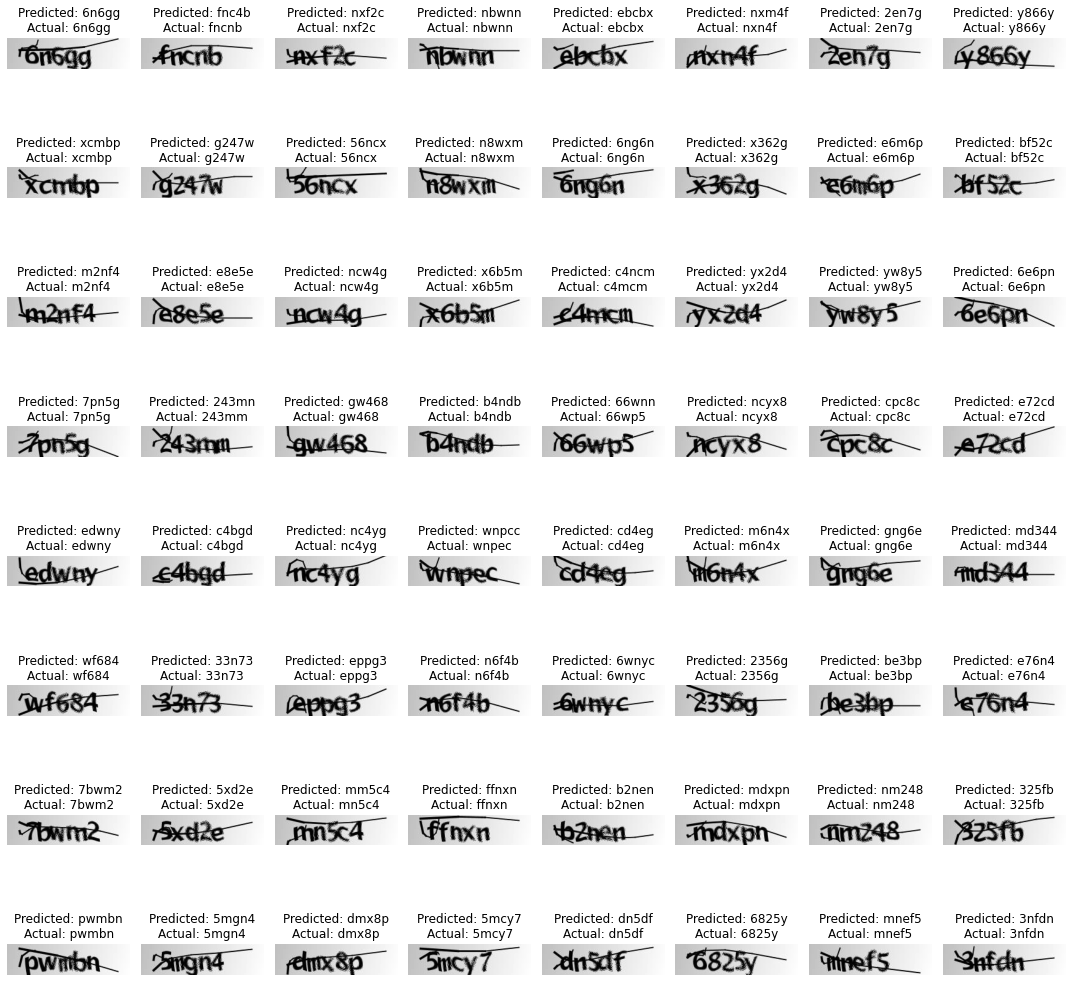

In [8]:
def prediction_image(folder_path):
    """
    Predict characters from images in a folder and display predictions alongside actual labels in an 8x8 grid.

    Parameters:
    folder_path (str): Path to the folder containing image files.

    Returns:
    None
    """

    def preprocess_image(img):
        # Preprocessing steps
        image = cv2.adaptiveThreshold(
            img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0
        )
        image = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 0
        )
        kernel = np.ones((5, 5), np.uint8)
        image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        kernel = np.ones((2, 2), np.uint8)
        image = cv2.dilate(image, kernel, iterations=1)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        return image

    def predict_characters(image_sections):
        # Prepare input for prediction
        X_pred = [
            tf.keras.preprocessing.image.img_to_array(Image.fromarray(section))
            for section in image_sections
        ]
        X_pred = np.array(X_pred) / 255.0

        # Make predictions
        y_pred = model.predict(X_pred)
        y_pred = np.argmax(y_pred, axis=1)

        return y_pred

    # Initialize subplots
    fig, axs = plt.subplots(8, 8, figsize=(15, 15))

    # Iterate through files in the folder
    for i, filename in enumerate(os.listdir(folder_path)):
        if i >= 64:  # Only process first 64 images
            break

        filepath = os.path.join(folder_path, filename)

        # Read image in grayscale
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

        # Preprocess image
        image = preprocess_image(img)

        # Extract character sections
        x = [
            image[10:50, 30:50],
            image[10:50, 50:70],
            image[10:50, 70:90],
            image[10:50, 90:110],
            image[10:50, 110:130],
        ]

        # Predict characters
        y_pred = predict_characters(x)

        # Display image and predictions in subplot
        ax = axs[i // 8, i % 8]
        ax.imshow(img, cmap="gray")
        ax.axis("off")
        predicted_text = "".join([info[res] for res in y_pred])
        actual_label = filename.split(".")[0]
        ax.set_title(f"Predicted: {predicted_text}\nActual: {actual_label}")

    plt.tight_layout()
    plt.show()


# Call the function with the path to the samples folder
prediction_image("./data/samples/")

## Model Saving

In [9]:
!rm -rf ./model
!mkdir "model"
model.save("./model/captcha_recognizer.h5")